In [ ]:
#@title Libraries and Global Variables
%%capture
!pip install colorama
from colorama import Fore, Style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
!pip install statsmodels==0.13.2
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
!pip install prophet
from prophet import Prophet
!pip install neuralprophet[live]
from neuralprophet import NeuralProphet
import time
pd.options.mode.chained_assignment = None

Test, Train, scaler = [], [], ''
df_result = pd.DataFrame(columns=['Model', 'MAE_Train', 'RMSE_Train', 'MAE_Test', 'RMSE_Test'])

# ***Libraries and Global Variables*** 👆

---

# ***Analyzing and Preprocessing*** 👇

In [ ]:
#@title Exploratory data analysis
def EDA(Train):
  
  df_temp = Train.copy()
  df_temp['Year'] = pd.to_datetime(df_temp.index).year
  df_temp['Month'] = pd.to_datetime(df_temp.index).month
  df_temp['Month Name'] = pd.to_datetime(df_temp.index).month_name()
  df_temp['Month-Year'] = pd.to_datetime(df_temp.index).strftime('%b.%Y')
  
  # Countplots
  figure, axes = plt.subplots(1, 2, figsize=(12, 4))
  figure.suptitle('Countplot')
  sns.countplot(data=df_temp, x='Year', ax=axes[0])
  axes[0].set_title('Year', fontweight="bold")
  sns.countplot(data=df_temp, x='Month', ax=axes[1])
  axes[1].set_title('Month', fontweight="bold")
  axes[1].tick_params(axis='x', labelrotation = 45)
  plt.show()

  # Drop duplicates
  df_temp.drop_duplicates(inplace=True)

  # Fill nan elements with the previous values
  print('\nNumber of NaN values in each column:')
  print(df_temp.isnull().sum())
  df_temp.fillna(method='ffill', inplace=True)

  # features correlations
  print()
  plt.figure(figsize=(6, 4))
  sns.heatmap(df_temp.corr())
  plt.title('Correlation between different columns:', fontweight="bold")
  plt.show()

  # Boxplot
  plt.figure(figsize=(20, 4))
  sns.boxplot(data=df_temp, x='Month-Year', y='meantemp', palette='Blues')
  plt.title('Boxplot of meantemp', fontweight="bold")
  plt.xticks(rotation=60)
  plt.show()

  # Remove outliers of each month
  print('\nRemoving outliers...')
  print(f'Length of the Train dataset before removing the outliers: {len(df_temp)}')
  for i in df_temp['Month-Year'].unique():
    
    dff_temp = df_temp.loc[df_temp['Month-Year']==i].copy()
    Q1 = dff_temp['meantemp'].quantile(0.25)
    Q3 = dff_temp['meantemp'].quantile(0.75)
    IQR = Q3 - Q1
    
    indx = dff_temp.loc[(dff_temp['meantemp']<(Q1-1.5*IQR))|(dff_temp['meantemp']>(Q3+1.5*IQR))].index.tolist()
    df_temp = df_temp.loc[~df_temp.index.isin(indx)]
  print(f'Length of the Train dataset after removing the outliers: {len(df_temp)}')

  return df_temp[Train.columns]

In [ ]:
#@title plot different features, their rolling averages and standard deviations
def plot_train_df(Train):
  
  fig, axes = plt.subplots(4, 1, figsize=(20,24))
  for counter, i in enumerate(Train.columns):
    axes[counter].plot(Train[i], 'g', marker='o', label=i)
    axes[counter].plot(Train[i].rolling(window=30).mean(), 'red', label='Rolling Mean')
    axes[counter].plot(Train[i].rolling(window=30).std(), 'gold', label='Rolling Standard deviation')
    # Define x-axis to be month and year 
    axes[counter].xaxis.set_major_locator(mdates.MonthLocator())
    axes[counter].xaxis.set_major_formatter(mdates.DateFormatter('%b.%Y'))
    axes[counter].tick_params(axis='x', labelrotation = 45)
    axes[counter].legend()
    print()
  plt.show()


In [ ]:
#@title Seasonal Decomposition of meantemp
def Seasonal_Decomposition(Train):
  decomposition = seasonal_decompose(x=Train['meantemp'], model='additive', period=6)
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid
  dic = {'Trend': trend, 'Seasonal': seasonal, 'Residual': residual}
  fig, axes = plt.subplots(3, 1, figsize=(20,16))
  for counter, i in enumerate(dic.keys()):
    axes[counter].plot(dic[i], label=i)
    # Define x-axis to be month and year 
    axes[counter].xaxis.set_major_locator(mdates.MonthLocator())
    axes[counter].xaxis.set_major_formatter(mdates.DateFormatter('%b.%Y'))
    axes[counter].tick_params(axis='x', labelrotation = 45)
    axes[counter].legend()
    axes[counter].set_title(i)
  plt.xlabel('Days from 01.01.2013 to 01.01.2017')
  plt.show()
  

In [ ]:
#@title Check Stationarity
def check_Stationarity():
  global Train
  # Dickey-Fuller test
  for i in Train.columns:
    if 'diff' not in i:
      print(f' --> Dickey-Fuller test on {i}')
      adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(Train[i].values)
      print('ADF test statistic:', adf)
      print('ADF p-values:', pval)
      print('ADF number of lags used:', usedlag)
      print('ADF number of observations:', nobs)
      print('ADF critical values:', crit_vals)
      print('ADF best information criterion:', icbest)
      # Check the conditions
      if (pval <= 0.05) & (crit_vals['5%'] > adf):
        print(f'{Fore.GREEN}\033[1mStationary\033[0m{Style.RESET_ALL}')
      else:
        print(f'{Fore.RED}\033[1mNon-Stationary\033[0m{Style.RESET_ALL}')
        cl = i + ' diff'
        Train[cl] = Train[i].diff()
      print()

In [ ]:
#@title Feature Engineering
def FE(which):
  # --------------------------------------
  # Based on the choice,create some features and prepare the datesets for the models 
  # --------------------------------------
  global Train, Test, scaler

  Trainset = Train[['meantemp']].copy()
  Testset = Test[['meantemp']].copy()

  if which == 'date':
    Trainset['month'] = pd.to_datetime(Train.index).month
    Trainset['Week_n'] = pd.to_datetime(Train.index).isocalendar().week
    Trainset['Day'] = pd.to_datetime(Train.index).day
    Testset['month'] = pd.to_datetime(Test.index).month
    Testset['Week_n'] = pd.to_datetime(Test.index).isocalendar().week
    Testset['Day'] = pd.to_datetime(Test.index).day
    display(Trainset)
    plt.figure(figsize=(6, 4))
    sns.heatmap(Trainset.corr())
    plt.show()
    Trainset = Trainset.to_numpy()
    Testset = Testset.to_numpy()

  else:
    if which == 'lag':
      # Add lags (The past values are known as lags) to the dataset. PACF plays an important role to get the right number of the lags
      for inc in range(1,6):
          field_name = 'lag_' + str(inc)
          Trainset[field_name] = Trainset['meantemp'].shift(inc)
          Testset[field_name] = Testset['meantemp'].shift(inc)

      Trainset = Trainset.dropna().reset_index(drop=True)
      Testset = Testset.dropna().reset_index(drop=True)
  
    elif which == 'window':
      rolling_mean = Trainset.rolling(window=5).mean()
      rolling_max = Trainset.rolling(window=5).max()
      rolling_min = Trainset.rolling(window=5).min()
      Trainset['rolling_mean'], Trainset['rolling_max'], Trainset['rolling_min'] = rolling_mean, rolling_max, rolling_min
      rolling_mean = Testset.rolling(window=5).mean()
      rolling_max = Testset.rolling(window=5).max()
      rolling_min = Testset.rolling(window=5).min()
      Testset['rolling_mean'], Testset['rolling_max'], Testset['rolling_min'] = rolling_mean, rolling_max, rolling_min
      Trainset = Trainset.dropna().reset_index(drop=True)
      Testset = Testset.dropna().reset_index(drop=True)

    display(Trainset)
    plt.figure(figsize=(6, 4))
    sns.heatmap(Trainset.corr())
    plt.show()
    # Scale the dataset
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(Trainset)
    Trainset = scaler.transform(Trainset)
    Testset = scaler.transform(Testset)
  
  return Trainset, Testset



# ***Preprocessing*** 👆

---

# ***Models and Results*** 👇

In [ ]:
#@title Unscaled the scaled Dataset
def unscaled(pred, X, scaler):

  # Inverse Transformation and inscaled the prediction to plot the unscaled result
  pred_test_set = []
  for i in range(len(pred)):
    pred_test_set.append(np.concatenate((np.array(pred[i]).reshape(1,), X[i])))
    
  unscaled_pred_test_set = scaler.inverse_transform(np.array(pred_test_set))
  return unscaled_pred_test_set

In [ ]:
#@title MAE and RMSE scores
def compare_results(model, preds_Train, preds_Test, train, test, scaler):
  global df_result, Test, Train

  if scaler != '':
    preds_Train = unscaled(preds_Train, train, scaler)
    preds_Test = unscaled(preds_Test, test, scaler)
    d_Train = Train.iloc[-len(preds_Train):]['meantemp'].values - preds_Train[:, 0]
    d_Test = Test.iloc[-len(preds_Test):]['meantemp'].values - preds_Test[:, 0]
  else:
    d_Train = train - preds_Train
    d_Test = test - preds_Test
  mae_Train = np.mean(abs(d_Train))
  rmse_Train = np.sqrt(np.mean(d_Train**2))
  mae_Test = np.mean(abs(d_Test))
  rmse_Test = np.sqrt(np.mean(d_Test**2))
  df_result.loc[len(df_result)] = [model, mae_Train, rmse_Train, mae_Test, rmse_Test]
  print(f'{model}: MAE_Train: {mae_Train} - RMSE_Train {rmse_Train} - MAE_Test {mae_Test} - RMSE_Test {rmse_Test}')


In [ ]:
#@title plot the target and predicted results
def result_plot(model, Y, Y_test, preds_Train, preds_Test, X_test, scaler):
  global Test
  # ----------------------------------
  # Plot the scaled and unscaled predictions and real values
  # ----------------------------------

  # Plot the scaled results
  fig, axes = plt.subplots(1, 2, figsize=[22, 4], gridspec_kw={'width_ratios': [2, 1]})
  # Trainset
  axes[0].plot(Y, 'darkslategray', label='Original')
  axes[0].plot(preds_Train, 'aqua', label='Predicted')
  axes[0].set_ylabel('scaled_meantemp')
  axes[0].set_xlabel('Days from 01.01.2013')
  axes[0].legend()
  axes[0].set_title(f'{model} Trainset', fontweight="bold")
  #Testset
  axes[1].plot(Y_test, 'darkslategray', label='Original')
  axes[1].plot(preds_Test, 'aqua', label='Predicted')
  axes[1].set_ylabel('scaled_meantemp')
  axes[1].set_xlabel('Days from 01.01.2017')
  axes[1].legend()
  axes[1].set_title(f'{model} Testset_Scaled', fontweight="bold")
  plt.show()

  
  if scaler != '':
    unscaled_pred_test_set = unscaled(preds_Test, X_test, scaler)
    df_result = pd.DataFrame({'meantemp':  unscaled_pred_test_set[:, 0]})
    df_result.index = Test.index[-len(unscaled_pred_test_set):]
    plt.figure(figsize=(8, 4))
    ax = plt.subplot()
    ax.plot(df_result['meantemp'], label='Predicted')
    ax.plot(Test['meantemp'], label='Original')
    ax.set_ylabel('meantemp')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b.%Y'))
    ax.tick_params(axis='x', labelrotation = 45)
    ax.legend()
    plt.show()

In [ ]:
#@title Linear Regression
def linearRegression(Trainset, Testset, scaler):
  X = np.array(Trainset[:, 1:])
  Y = np.array(Trainset[:, 0:1]).reshape(len(Trainset[:, 0:1]))
  X_test = np.array(Testset[:, 1:])
  Y_test = np.array(Testset[:, 0:1]).reshape(len(Testset[:, 0:1]))
  # Train model
  mlr = LinearRegression()
  mlr.fit(X, Y)
  # Trainset
  preds_Train = mlr.predict(X)
  # Testset
  preds_Test = mlr.predict(X_test)
  # plot the predictions
  result_plot('Linear Regression', Y, Y_test, preds_Train, preds_Test, X_test, scaler)
  # scores
  now = time.localtime() 
  t = str(now.tm_min)+'.'+str(now.tm_sec) 
  compare_results(f'Linear Regression ({t})', preds_Train, preds_Test, X, X_test, scaler)

In [ ]:
#@title Random Forest
def RandomForest(Trainset, Testset, scaler, Max_depth):
  X = np.array(Trainset[:, 1:])
  Y = np.array(Trainset[:, 0:1]).reshape(len(Trainset[:, 0:1]))
  X_test = np.array(Testset[:, 1:])
  Y_test = np.array(Testset[:, 0:1]).reshape(len(Testset[:, 0:1]))
  # Train model
  rf = RandomForestRegressor(max_depth=Max_depth)
  rf.fit(X, Y)
  # Trainset
  preds_Train = rf.predict(X)
  # Testset
  preds_Test = rf.predict(X_test)
  # plot the predictions
  result_plot('Random Forest', Y, Y_test, preds_Train, preds_Test, X_test, scaler)
  # scores
  now = time.localtime() 
  t = str(now.tm_min)+'.'+str(now.tm_sec) 
  compare_results(f'Random Forest max_depth={Max_depth} ({t})', preds_Train, preds_Test, X, X_test, scaler)

In [ ]:
#@title XGBoost
def XGBoost(Trainset, Testset, scaler, lr, Max_depth):
  X = np.array(Trainset[:, 1:])
  Y = np.array(Trainset[:, 0:1]).reshape(len(Trainset[:, 0:1]))
  X_test = np.array(Testset[:, 1:])
  Y_test = np.array(Testset[:, 0:1]).reshape(len(Testset[:, 0:1]))
  # Train model
  XGb = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=lr, max_depth=Max_depth)
  XGb.fit(X, Y)
  # Trainset
  preds_Train = XGb.predict(X)
  # Testset
  preds_Test = XGb.predict(X_test)
  # plot the predictions
  result_plot('XGBoost', Y, Y_test, preds_Train, preds_Test, X_test, scaler)
  # scores
  now = time.localtime() 
  t = str(now.tm_min)+'.'+str(now.tm_sec) 
  compare_results(f'XGBoost lr={lr} & max_depth={Max_depth} ({t})', preds_Train, preds_Test, X, X_test, scaler)

In [ ]:
#@title SARIMA
def SARIMA():
  global Train, Test
  
  df = Train[['meantemp']]
  df.index = pd.DatetimeIndex(Train.index).to_period('D')
  model = SARIMAX(df['meantemp'], order=(1, 1, 3), seasonal_order=(1, 1, 1, 365)).fit()
  print(model.summary())
  #Diagnosing the model residuals
  model.plot_diagnostics(figsize=(10,8))
  forecast = model.forecast(Test.index[-1])
  display(forecast)
  


In [ ]:
#@title Prophet and NeuralProphet
def NeuralProphet_FB():
  global Train, Test
  # Dataframe for Prophet should only have ds and y columns
  df = Train[["meantemp"]] 
  df.rename(columns={"meantemp": "y"}, inplace=True)
  df['ds'] = pd.to_datetime(Train.index)
  future = pd.DataFrame()
  future['ds'] = pd.to_datetime(Test.index)
  
  # Train Prophet
  model = Prophet(weekly_seasonality=False, daily_seasonality=False)
  model.fit(df)
  forecast_1 = model.predict(df)
  forecast_2 = model.predict(future)
  model.plot_components(forecast_2)
  # plot the result
  fig, axes = plt.subplots(1, 2, figsize=[22, 6], gridspec_kw={'width_ratios': [2, 1]})
  # Trainset
  model.plot(forecast_1, xlabel="Date", ylabel="Temp", ax=axes[0])
  axes[0].set_title(f'Prophet Trainset', fontweight="bold")
  # Testset
  model.plot(forecast_2, xlabel="Date", ylabel="Temp", ax=axes[1])
  axes[1].set_title(f'Prophet Testset', fontweight="bold")
  plt.show()
  # Scores
  now = time.localtime() 
  t = str(now.tm_min)+'.'+str(now.tm_sec) 
  compare_results(f'Prophet ({t})', forecast_1['yhat'].values, forecast_2['yhat'], df['y'].values, Test['meantemp'].values, '')
  print('-----')
  # Train NeuralProphet
  future['y'] = Test['meantemp'].values
  lags = 5
  model = NeuralProphet(n_lags=lags, learning_rate=0.01, num_hidden_layers=1, seasonality_reg=0.2, weekly_seasonality=False, daily_seasonality=False)
  df_train, df_val = model.split_df(df, freq='D', valid_p = 0.2)
  metrics = model.fit(df_train, freq='D', validation_df=df_val)
  forecast = model.predict(df)
  forecast_2 = model.predict(future)
  model.plot_components(forecast_2)
  # plot the result
  fig, axes = plt.subplots(1, 2, figsize=[22, 6], gridspec_kw={'width_ratios': [2, 1]})
  # Trainset
  model.plot(forecast, xlabel="Date", ylabel="Temp", ax=axes[0])
  axes[0].set_title(f'NeuralProphet Trainset', fontweight="bold")
  # Testset
  model.plot(forecast_2, xlabel="Date", ylabel="Temp", ax=axes[1])
  axes[1].set_title(f'NeuralProphet Testset', fontweight="bold")
  plt.show()
  # Scores
  compare_results('NeuralProphet', forecast.iloc[lags:]['yhat1'].values, forecast_2.iloc[lags:]['yhat1'].values, forecast.iloc[lags:]['y'].values, forecast_2.iloc[lags:]['y'].values, '')


# ***Models and Results*** 👆

---

# ***Main*** 👇

In [ ]:
#@title Main
# Load Data 
Train = pd.read_csv('/content/DailyDelhiClimateTrain.csv')
Test = pd.read_csv('/content/DailyDelhiClimateTest.csv')

Train.set_index('date', inplace=True)
Train.index = pd.to_datetime(Train.index).date
Test.set_index('date', inplace=True)
Test.index = pd.to_datetime(Test.index).date
display(Train.head())
print()
Train.info()
print()
Train.describe()

,meantemp,humidity,wind_speed,meanpressure
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000



<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB



,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


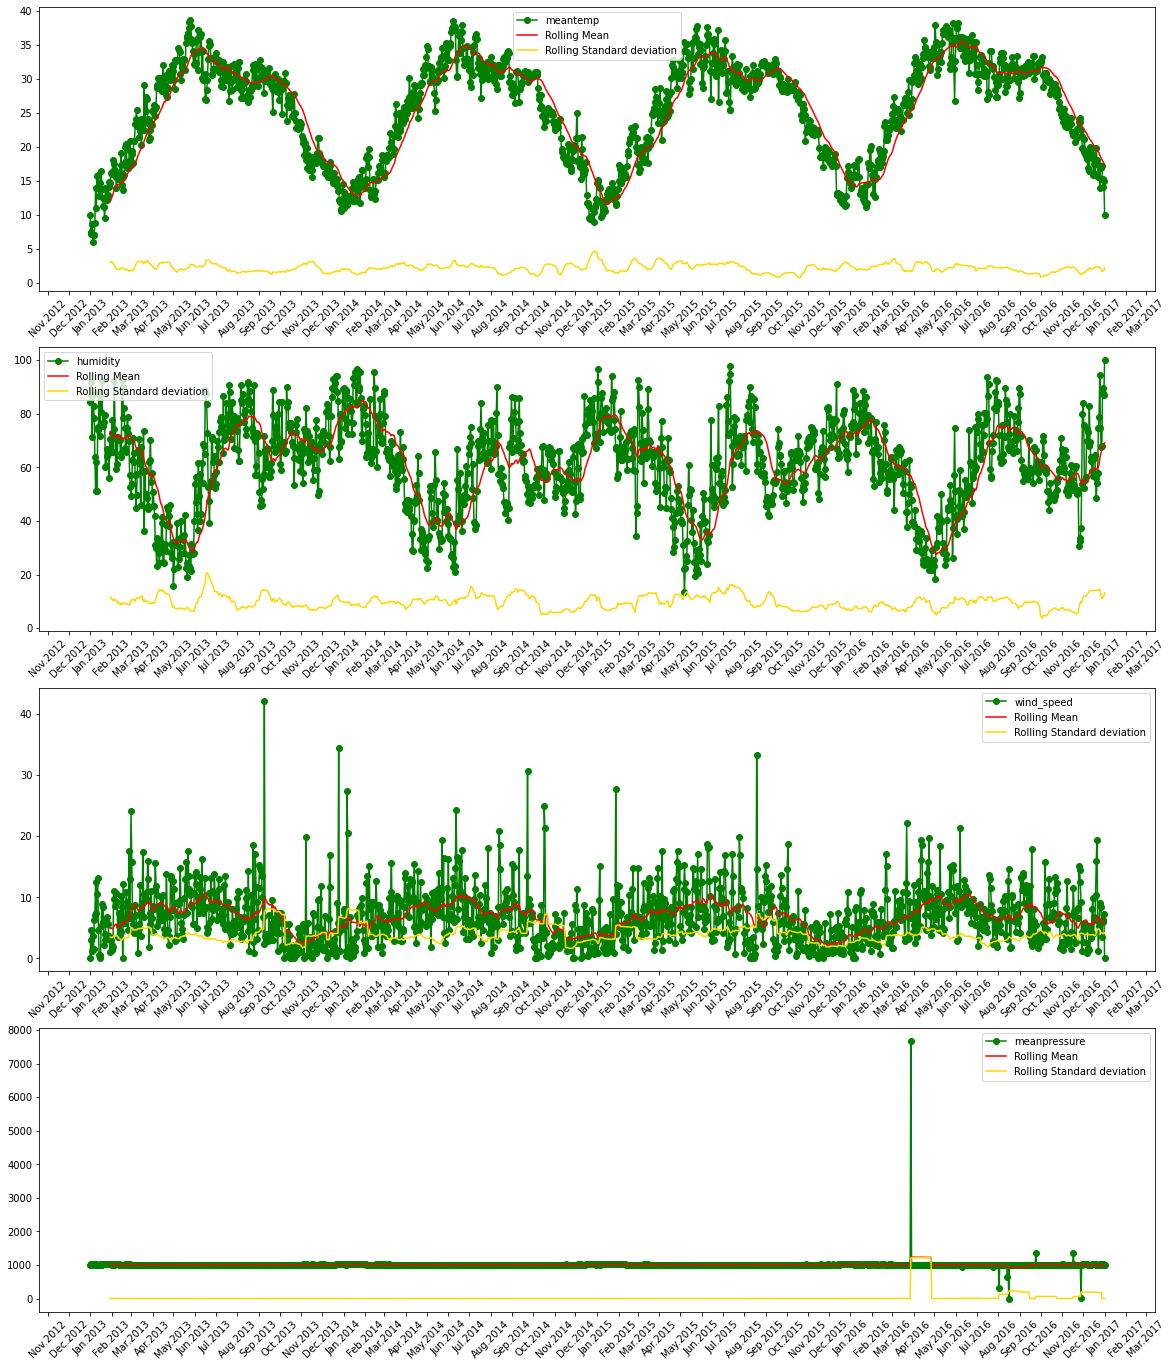

In [ ]:
plot_train_df(Train)

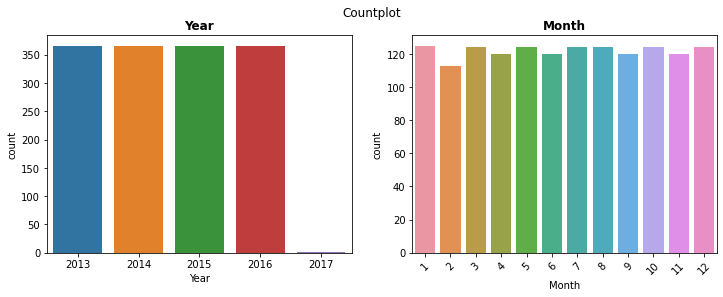


Number of NaN values in each column:
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
Year            0
Month           0
Month Name      0
Month-Year      0
dtype: int64



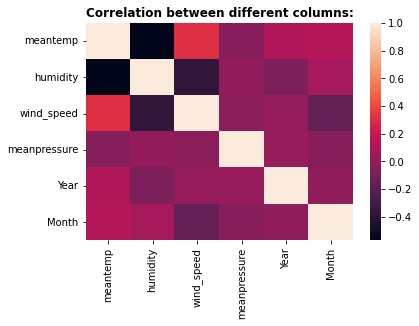

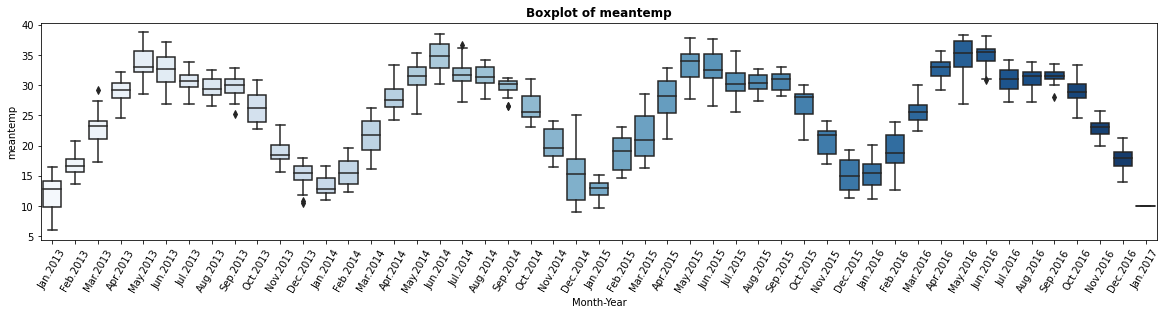


Removing outliers...
Length of the Train dataset before removing the outliers: 1462
Length of the Train dataset after removing the outliers: 1453


In [ ]:
Train = EDA(Train)

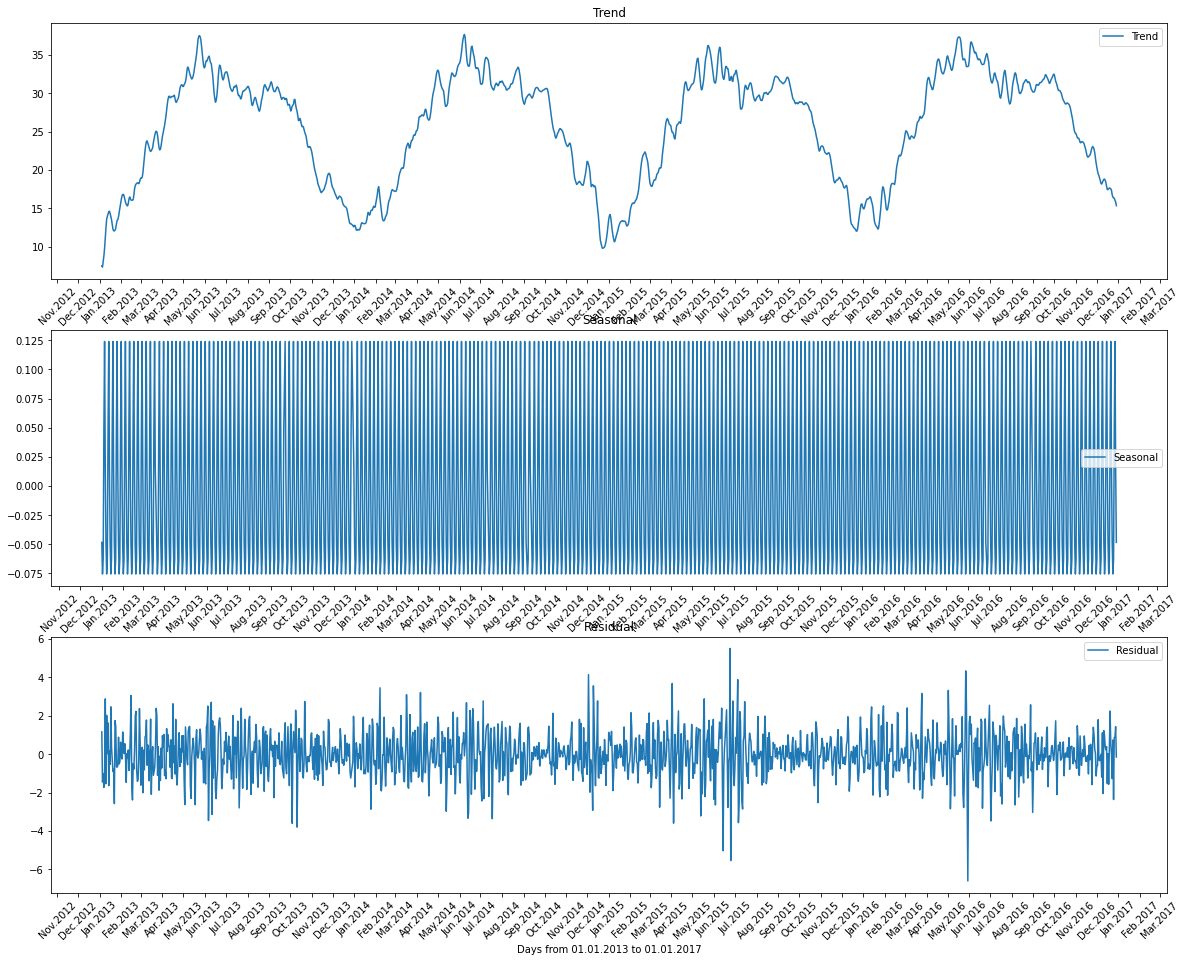

In [ ]:
Seasonal_Decomposition(Train)

In [ ]:
check_Stationarity()

 --> Dickey-Fuller test on meantemp
ADF test statistic: -2.0220330080468156
ADF p-values: 0.27699672571834094
ADF number of lags used: 10
ADF number of observations: 1442
ADF critical values: {'1%': -3.4348929812602784, '5%': -2.863546418485167, '10%': -2.5678382024888378}
ADF best information criterion: 5352.472449240409
Non-Stationary

 --> Dickey-Fuller test on humidity
ADF test statistic: -3.6385497805374367
ADF p-values: 0.005065393863600835
ADF number of lags used: 15
ADF number of observations: 1437
ADF critical values: {'1%': -3.434908816804013, '5%': -2.863553406963303, '10%': -2.5678419239852994}
ADF best information criterion: 9864.954782553821
Stationary

 --> Dickey-Fuller test on wind_speed
ADF test statistic: -3.847707942966741
ADF p-values: 0.002455230348724295
ADF number of lags used: 24
ADF number of observations: 1428
ADF critical values: {'1%': -3.4349376007389965, '5%': -2.8635661096787812, '10%': -2.567848688436159}
ADF best information criterion: 8048.28516522409

meantemp


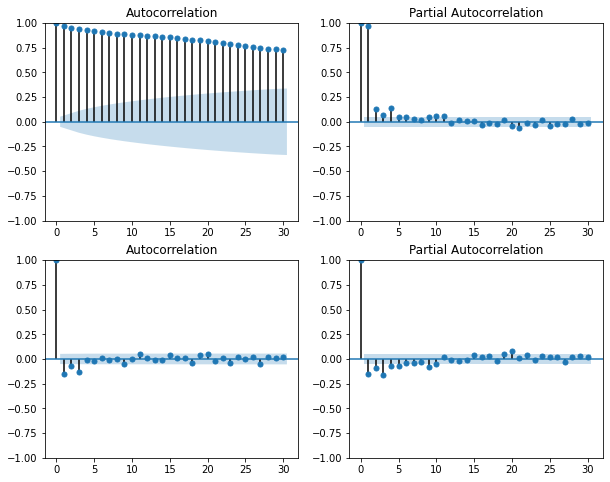

meantemp diff


In [ ]:
# AFC and PACF: the autocorrelation function for meantemp
print('meantemp')
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
acf = plot_acf(Train['meantemp'], lags=30, ax=axes[0][0])
pacf = plot_pacf(Train['meantemp'], lags=30, method='ywm', ax=axes[0][1])
if 'meantemp diff' in Train.columns:
  acf = plot_acf(Train['meantemp diff'].dropna(), lags=30, ax=axes[1][0])
  pacf = plot_pacf(Train['meantemp diff'].dropna(), lags=30, method='ywm', ax=axes[1][1])
plt.show()
print('meantemp diff')

,meantemp,lag_1,lag_2,lag_3,lag_4,lag_5
0,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000
1,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000
2,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667
3,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667
4,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000
...,...,...,...,...,...,...
1443,17.217391,16.850000,17.142857,14.000000,17.318182,15.550000
1444,15.238095,17.217391,16.850000,17.142857,14.000000,17.318182
1445,14.095238,15.238095,17.217391,16.850000,17.142857,14.000000
1446,15.052632,14.095238,15.238095,17.217391,16.850000,17.142857


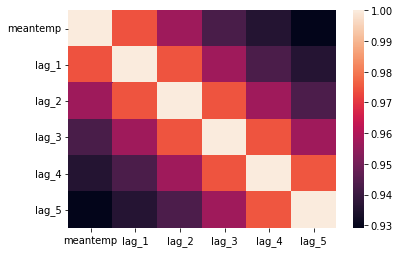

In [ ]:
scaler = ''
# which = 'lag' or 'date' or 'window'
Trainset, Testset = FE(which='lag')

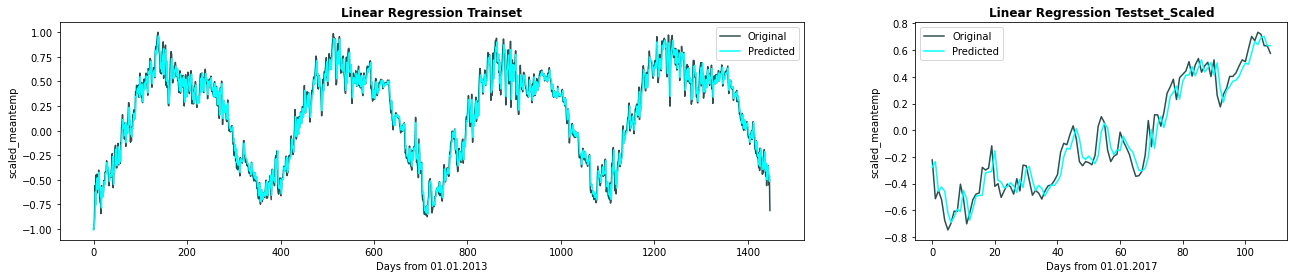

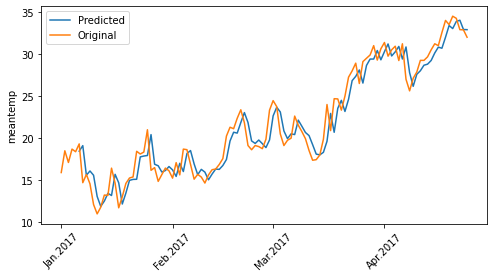

Linear Regression (53.47): MAE_Train: 1.9227814200469957 - RMSE_Train 2.5164395605272474 - MAE_Test 1.3477777196647798 - RMSE_Test 1.705885686354578


In [ ]:
linearRegression(Trainset, Testset, scaler)

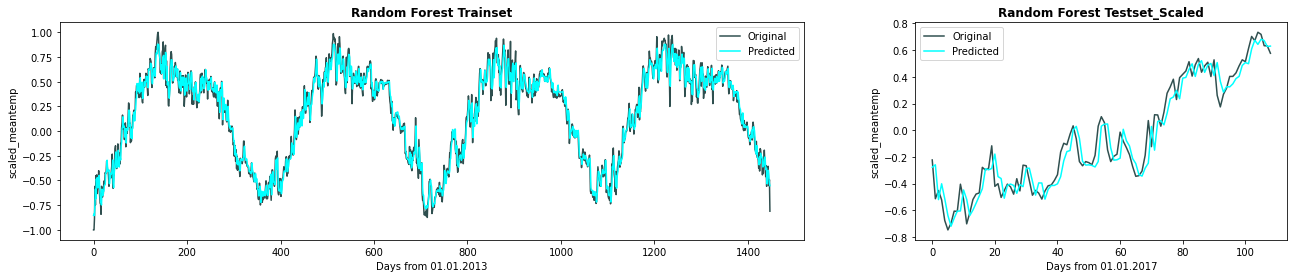

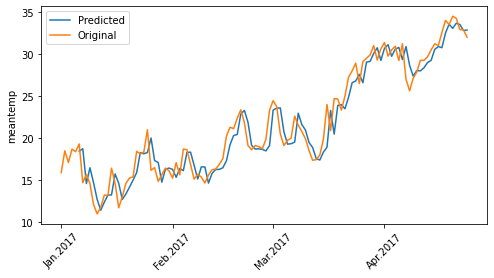

Random Forest max_depth=5 (53.54): MAE_Train: 1.8524027951474615 - RMSE_Train 2.416341085279313 - MAE_Test 1.3423178850895519 - RMSE_Test 1.7147102718704117


In [ ]:
RandomForest(Trainset, Testset, scaler, Max_depth=5)

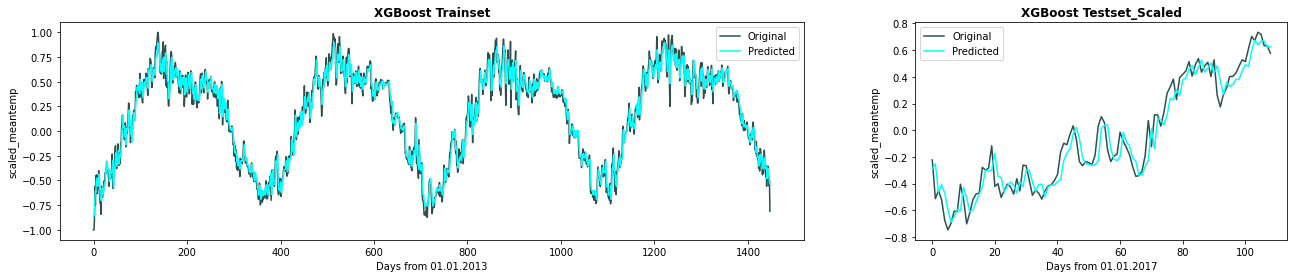

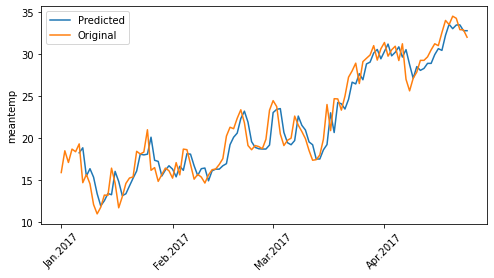

XGBoost lr=0.05 & max_depth=3 (53.59): MAE_Train: 1.845665923738424 - RMSE_Train 2.393178180689409 - MAE_Test 1.348982717881543 - RMSE_Test 1.725493973998193


In [ ]:
XGBoost(Trainset, Testset, scaler, lr=0.05, Max_depth=3)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprr1nkgph/7ehss2lc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprr1nkgph/fo4fsv9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56225', 'data', 'file=/tmp/tmprr1nkgph/7ehss2lc.json', 'init=/tmp/tmprr1nkgph/fo4fsv9i.json', 'output', 'file=/tmp/tmprr1nkgph/prophet_modelqopfytev/prophet_model-20221025140153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


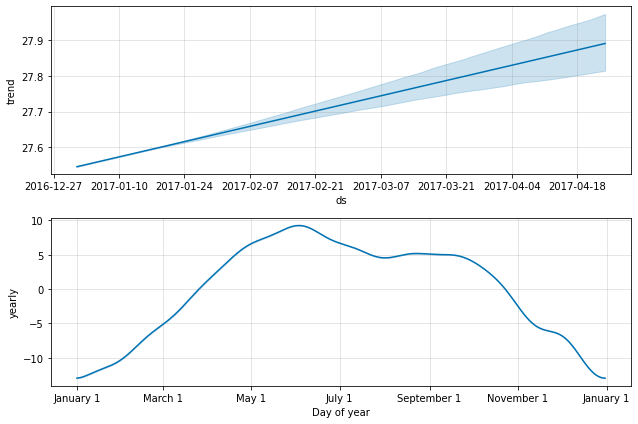

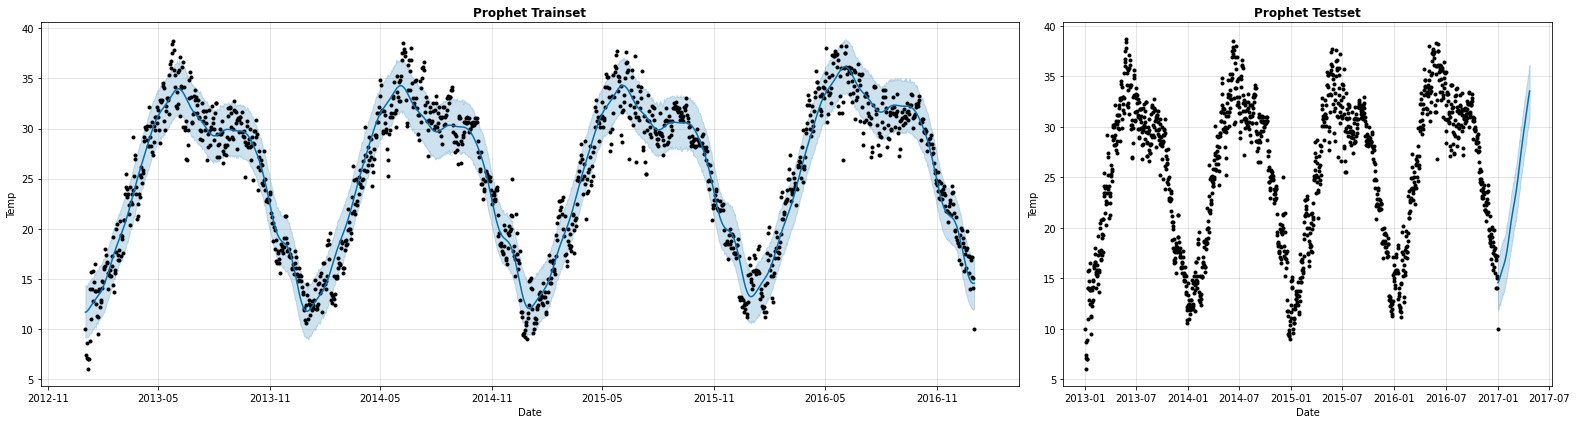

INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
INFO:NP.df_utils:Major frequency D corresponds to 99.932% of the data.
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO:NP.df_utils:Major frequency D corresponds to 99.915% of the data.
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.


Prophet (1.56): MAE_Train: 1.601535180369172 - RMSE_Train 2.034596896185213 - MAE_Test 2.1981298571746484 - RMSE_Test 2.6829575290812255
-----


INFO:NP.config:Auto-set batch_size to 32
INFO:NP.config:Auto-set epochs to 185
  0%|          | 0/185 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:922: UserWarning: Using a target size (torch.Size([291])) that is different to the input size (torch.Size([291, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

Epoch[185/185]: 100%|██████████| 185/185 [00:23<00:00,  7.74it/s, SmoothL1Loss=0.0014, MAE=1.16, RMSE=1.51, Loss=0.00104, RegLoss=3.4e-6, MAE_val=6.08, RMSE_val=7.91, SmoothL1Loss_val=0.0376]
INFO:NP.df_utils:Major frequency D corresponds to 99.932% of the data.
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Major frequency D corresponds to 99.932% of the data.
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Returnin

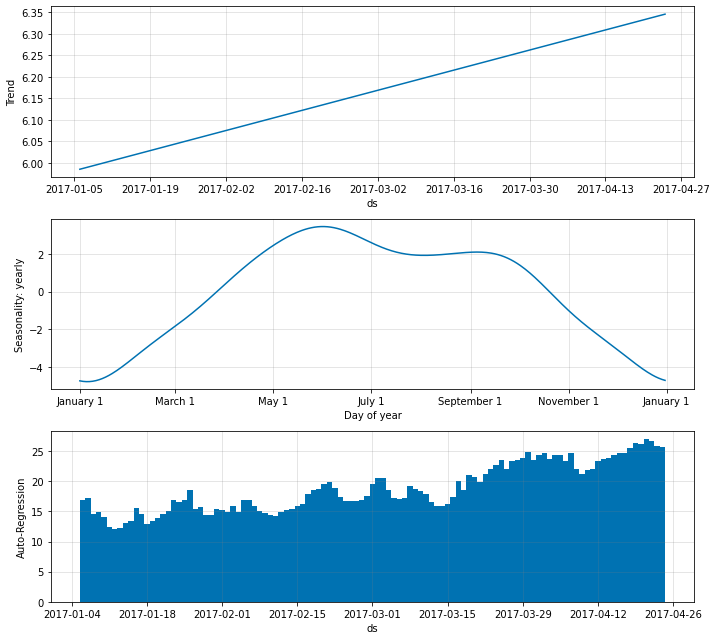

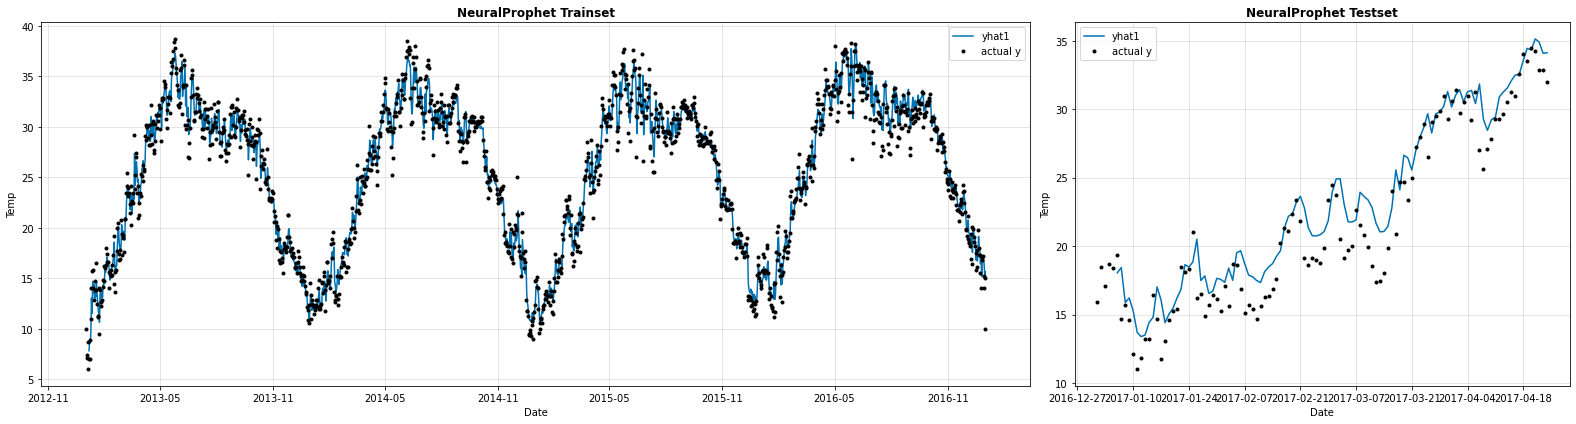

NeuralProphet: MAE_Train: 1.1741995776048728 - RMSE_Train 1.5626435596650765 - MAE_Test 1.6718272504030143 - RMSE_Test 2.084953726415126


In [ ]:
NeuralProphet_FB()

,Model,MAE_Train,RMSE_Train,MAE_Test,RMSE_Test
0,Linear Regression (53.47),1.922781,2.516440,1.347778,1.705886
1,Random Forest max_depth=5 (53.54),1.852403,2.416341,1.342318,1.714710
2,XGBoost lr=0.05 & max_depth=3 (53.59),1.845666,2.393178,1.348983,1.725494
3,Prophet (1.56),1.601535,2.034597,2.198130,2.682958
4,NeuralProphet,1.174200,1.562644,1.671827,2.084954


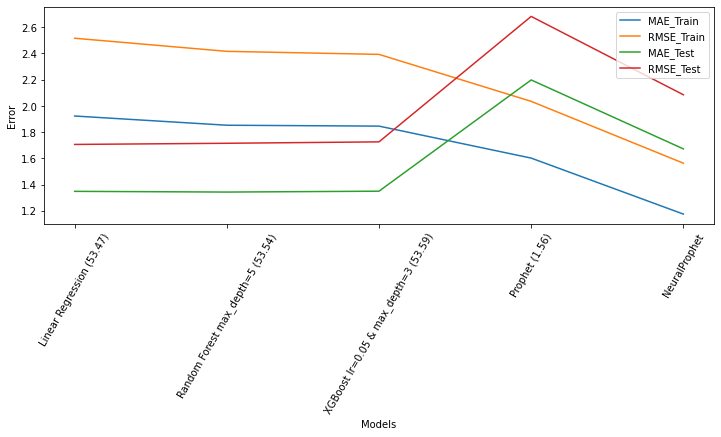

In [ ]:
display(df_result)
fig = plt.figure(figsize=(12, 4))
for i in df_result.drop(columns=['Model']).columns:
  plt.plot(df_result['Model'], df_result[i], label=i)
plt.xlabel('Models')
plt.xticks(rotation=60)
plt.ylabel('Error')
plt.legend()
plt.show()